# Visualization of Similarity Analysis for llc_modis_curl

In [6]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [8]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import plotting
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction
from ulmo.plotting import load_palette

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
llc_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl_kin/experiments/llc_modis_2012_curl_latents/"
llc_curl_reduced_latents = os.path.join(llc_curl_path, os.listdir(llc_curl_path)[1])

In [13]:
llc_curl_reduced_latents = pd.read_feather(llc_curl_reduced_latents).values

In [12]:
llc_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl_kin/experiments/llc_modis_2012_curl_latents/"
llc_curl_latents_file = os.path.join(llc_curl_path, os.listdir(llc_curl_path)[0])

In [18]:
with h5py.File(llc_curl_latents_file, 'r') as f:
    llc_curl_latents = f['valid'][:]

-------------
## Plot the similarity scatter plot

In [19]:
llc_curl_latents.shape

(635295, 256)

In [20]:
llc_curl_reduced_latents.shape

(635295, 2)

In [21]:
reduced_latent_x = np.median(llc_curl_reduced_latents[:, 0])

In [22]:
reduced_x_index_lower = np.argwhere(reduced_latent_x - 0.1 < llc_curl_reduced_latents[:, 0])
reduced_x_index_upper = np.argwhere(reduced_latent_x + 0.1 > llc_curl_reduced_latents[:, 0])

In [23]:
reduced_x_index = set(reduced_x_index_lower.squeeze(axis=1)) & set(reduced_x_index_upper.squeeze(axis=1))

In [24]:
reduced_x_index = np.array(list(reduced_x_index))

In [25]:
reduced_latent_y = np.sort(llc_curl_reduced_latents[reduced_x_index, 1])[reduced_x_index.shape[0] // 2]

In [26]:
reduced_y_index = np.argwhere(llc_curl_reduced_latents == reduced_latent_y)

In [27]:
center_index = set(reduced_x_index) & set(reduced_y_index[0])

In [28]:
reduced_latent_center = llc_curl_reduced_latents[list(center_index)[0]]

In [29]:
sim_matrix = cosine_similarity(np.array([llc_curl_latents[list(center_index)[0]]]), llc_curl_latents)

In [30]:
sim_matrix.squeeze(axis=0).shape

(635295,)

In [33]:
num_samples = llc_curl_reduced_latents.shape[0]
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

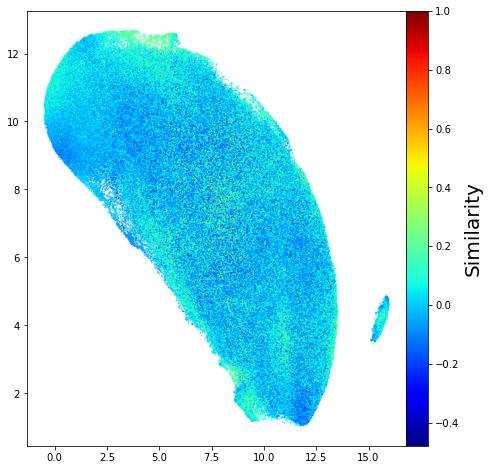

In [90]:
plt.figure(figsize=(width//dpi, height//dpi))
ax = plt.gca()
vmin, vmax = np.min(sim_matrix.squeeze(axis=0)), np.max(sim_matrix.squeeze(axis=0))
img = ax.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size, 
            c=sim_matrix.squeeze(axis=0), cmap='jet', vmin=vmin, vmax=vmax)
cb = plt.colorbar(img, pad=0.)
cb.set_label('Similarity', fontsize=20.)

------------------------

## Similarity Gallery

In [34]:
def set_fontsize(ax, fsz):
    """
    Set the fontsize throughout an Axis
    Args:
        ax (Matplotlib Axis):
        fsz (float): Font size
    Returns:
    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)

In [91]:
def umap_gallery(main_tbl, data_array, outfile=None, point_sz_scl=1., width=800, 
                 height=800, vmnx=(-1000.,None), dxdy=(0.3, 0.3),
                 Nx=20, debug=None):
    """Generate a UMAP plot and overplot a gallery
    of cutouts
    Args:
        main_tbl (pandas.DataFrame): Table of quantities.
        data_array (np.array): Cutouts images.
        outfile (str, optional): Outfile for the figure. Defaults to None.
        point_sz_scl (float, optional): Point size for UMAP points. Defaults to 1..
        width (int, optional): Width of the figure. Defaults to 800.
        height (int, optional): Height of the figure. Defaults to 800.
        vmnx (tuple, optional): Color bar vmin,vmax. Defaults to (-1000.,None).
        dxdy (tuple, optional): Amount to pad the xlim, ylim by. Defaults to (0.3, 0.3).
        Nx (int, optional): Number of cutout images in x to show. Defaults to 20.
        debug (bool, optional): Debug? Defaults to None.
    Returns:
        matplotlib.plt.Axes: Axis
    """

    _, cm = load_palette()

    num_samples = len(main_tbl)
    point_size = point_sz_scl / np.sqrt(num_samples)
    dpi = 100
    
    vmin, vmax = np.min(data_array), np.max(data_array)
    # New plot
    plt.figure(figsize=(width//dpi, height//dpi))
    ax = plt.gca()
    img = ax.scatter(main_tbl.U0, main_tbl.U1,
            s=point_size, cmap='jet', c=data_array, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(img, pad=0.)
    cb.set_label('Similarity', fontsize=20.)
    #
    ax.set_xlabel(r'$U_0$')
    ax.set_ylabel(r'$U_1$')

    # Set boundaries
    xmin, xmax = main_tbl.U0.min()-dxdy[0], main_tbl.U0.max()+dxdy[0]
    ymin, ymax = main_tbl.U1.min()-dxdy[1], main_tbl.U1.max()+dxdy[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ###################
    # Gallery time

    # Grid
    xval = np.linspace(xmin, xmax, num=Nx)
    dxv = xval[1]-xval[0]
    yval = np.arange(ymin, ymax+dxv, step=dxv)

    # Ugly for loop
    pp_hf = None
    ndone = 0
    if debug:
        nmax = 100
    else:
        nmax = 1000000000
    for x in xval[:-1]:
        for y in yval[:-1]:
            pts = np.where((main_tbl.U0 >= x) & (main_tbl.U0 < x+dxv) & (
                main_tbl.U1 >= y) & (main_tbl.U1 < y+dxv))[0]
            if len(pts) == 0:
                continue

            # Pick a random one
            ichoice = np.random.choice(len(pts), size=1)
            idx = int(pts[ichoice])
            sim_img = np.ones((64, 64)) * data_array[idx]

            # Image
            axins = ax.inset_axes(
                    [x, y, 0.9*dxv, 0.9*dxv], 
                    transform=ax.transData)
            _ = sns.heatmap(np.flipud(sim_img), xticklabels=[], 
                     vmin=vmin, vmax=vmax,
                     yticklabels=[], cmap='jet', cbar=False,
                     ax=axins)
            ndone += 1
            #print(f'ndone= {ndone}, LL={cutout.LL}')
            if ndone > nmax:
                break
        if ndone > nmax:
            break

    set_fontsize(ax, 15.)
    ax.set_aspect('equal', 'datalim')
    # Finish
    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"Wrote: {outfile}")

    return ax

In [92]:
valid_tbl = {}
valid_tbl['U0'] = llc_curl_reduced_latents[:, 0]
valid_tbl['U1'] = llc_curl_reduced_latents[:, 1]
valid_tbl = pd.DataFrame(valid_tbl)

Wrote: ./sim_gallery_epoch_20.png


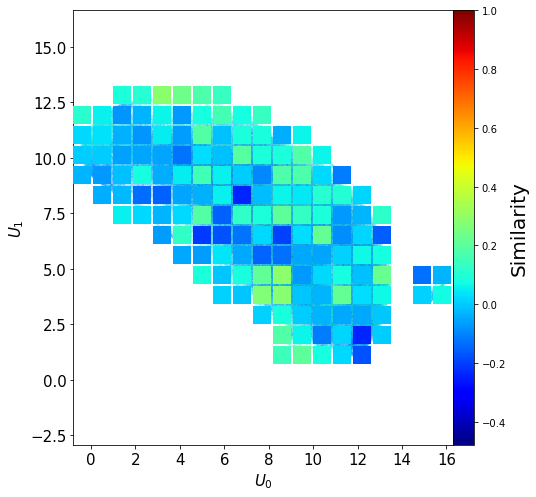

In [93]:
sim_gallery_file = './sim_gallery_epoch_20.png'
ax = umap_gallery(valid_tbl, sim_matrix.squeeze(axis=0), sim_gallery_file)

In [96]:
def umap_gallery(main_tbl, data_array, outfile=None, point_sz_scl=1., width=800, 
                 height=800, vmnx=(-1000.,None), dxdy=(0.3, 0.3),
                 Nx=20, debug=None):
    """Generate a UMAP plot and overplot a gallery
    of cutouts
    Args:
        main_tbl (pandas.DataFrame): Table of quantities.
        data_array (np.array): Cutouts images.
        outfile (str, optional): Outfile for the figure. Defaults to None.
        point_sz_scl (float, optional): Point size for UMAP points. Defaults to 1..
        width (int, optional): Width of the figure. Defaults to 800.
        height (int, optional): Height of the figure. Defaults to 800.
        vmnx (tuple, optional): Color bar vmin,vmax. Defaults to (-1000.,None).
        dxdy (tuple, optional): Amount to pad the xlim, ylim by. Defaults to (0.3, 0.3).
        Nx (int, optional): Number of cutout images in x to show. Defaults to 20.
        debug (bool, optional): Debug? Defaults to None.
    Returns:
        matplotlib.plt.Axes: Axis
    """

    _, cm = load_palette()

    num_samples = len(main_tbl)
    point_size = point_sz_scl / np.sqrt(num_samples)
    dpi = 100
    
    vmin, vmax = np.min(data_array), np.max(data_array)
    # New plot
    plt.figure(figsize=(width//dpi, height//dpi))
    ax = plt.gca()
    img = ax.scatter(main_tbl.U0, main_tbl.U1,
            s=point_size, cmap='jet', c=data_array, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(img, pad=0.)
    cb.set_label('Similarity', fontsize=20.)
    #
    ax.set_xlabel(r'$U_0$')
    ax.set_ylabel(r'$U_1$')

    # Set boundaries
    xmin, xmax = main_tbl.U0.min()-dxdy[0], main_tbl.U0.max()+dxdy[0]
    ymin, ymax = main_tbl.U1.min()-dxdy[1], main_tbl.U1.max()+dxdy[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ###################
    # Gallery time

    # Grid
    xval = np.linspace(xmin, xmax, num=Nx)
    dxv = xval[1]-xval[0]
    yval = np.arange(ymin, ymax+dxv, step=dxv)

    # Ugly for loop
    pp_hf = None
    ndone = 0
    if debug:
        nmax = 100
    else:
        nmax = 1000000000
    for x in xval[:-1]:
        for y in yval[:-1]:
            pts = np.where((main_tbl.U0 >= x) & (main_tbl.U0 < x+dxv) & (
                main_tbl.U1 >= y) & (main_tbl.U1 < y+dxv))[0]
            if len(pts) == 0:
                continue

            # Pick a random one
            #ichoice = np.random.choice(len(pts), size=1)
            #idx = int(pts[ichoice])
            sim_img = np.ones((64, 64)) * np.mean(data_array[pts])

            # Image
            axins = ax.inset_axes(
                    [x, y, 0.9*dxv, 0.9*dxv], 
                    transform=ax.transData)
            _ = sns.heatmap(np.flipud(sim_img), xticklabels=[], 
                     vmin=vmin, vmax=vmax,
                     yticklabels=[], cmap='jet', cbar=False,
                     ax=axins)
            ndone += 1
            #print(f'ndone= {ndone}, LL={cutout.LL}')
            if ndone > nmax:
                break
        if ndone > nmax:
            break

    set_fontsize(ax, 15.)
    ax.set_aspect('equal', 'datalim')
    # Finish
    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"Wrote: {outfile}")

    return ax

In [97]:
valid_tbl = {}
valid_tbl['U0'] = llc_curl_reduced_latents[:, 0]
valid_tbl['U1'] = llc_curl_reduced_latents[:, 1]
valid_tbl = pd.DataFrame(valid_tbl)

Wrote: ./sim_mean_gallery_epoch_20.png


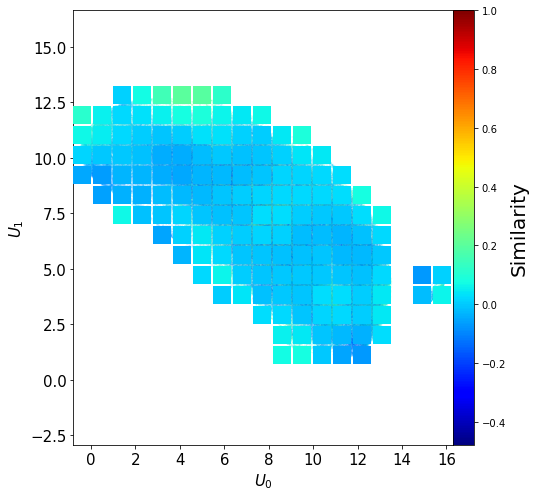

In [98]:
sim_gallery_file = './sim_mean_gallery_epoch_20.png'
ax = umap_gallery(valid_tbl, sim_matrix.squeeze(axis=0), sim_gallery_file)

In [31]:
def umap_gallery(main_tbl, data_array, outfile=None, point_sz_scl=1., width=800, 
                 height=800, vmnx=(-1000.,None), dxdy=(0.3, 0.3),
                 Nx=20, debug=None):
    """Generate a UMAP plot and overplot a gallery
    of cutouts
    Args:
        main_tbl (pandas.DataFrame): Table of quantities.
        data_array (np.array): Cutouts images.
        outfile (str, optional): Outfile for the figure. Defaults to None.
        point_sz_scl (float, optional): Point size for UMAP points. Defaults to 1..
        width (int, optional): Width of the figure. Defaults to 800.
        height (int, optional): Height of the figure. Defaults to 800.
        vmnx (tuple, optional): Color bar vmin,vmax. Defaults to (-1000.,None).
        dxdy (tuple, optional): Amount to pad the xlim, ylim by. Defaults to (0.3, 0.3).
        Nx (int, optional): Number of cutout images in x to show. Defaults to 20.
        debug (bool, optional): Debug? Defaults to None.
    Returns:
        matplotlib.plt.Axes: Axis
    """

    _, cm = load_palette()

    num_samples = len(main_tbl)
    point_size = point_sz_scl / np.sqrt(num_samples)
    dpi = 100
    
    vmin, vmax = np.min(data_array), np.max(data_array)
    # New plot
    plt.figure(figsize=(width//dpi, height//dpi))
    ax = plt.gca()
    img = ax.scatter(main_tbl.U0, main_tbl.U1,
            s=point_size, cmap='jet', c=data_array, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(img, pad=0.)
    cb.set_label('Similarity', fontsize=20.)
    #
    ax.set_xlabel(r'$U_0$')
    ax.set_ylabel(r'$U_1$')

    # Set boundaries
    xmin, xmax = main_tbl.U0.min()-dxdy[0], main_tbl.U0.max()+dxdy[0]
    ymin, ymax = main_tbl.U1.min()-dxdy[1], main_tbl.U1.max()+dxdy[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ###################
    # Gallery time

    # Grid
    xval = np.linspace(xmin, xmax, num=Nx)
    dxv = xval[1]-xval[0]
    yval = np.arange(ymin, ymax+dxv, step=dxv)

    # Ugly for loop
    pp_hf = None
    ndone = 0
    if debug:
        nmax = 100
    else:
        nmax = 1000000000
    for x in xval[:-1]:
        for y in yval[:-1]:
            pts = np.where((main_tbl.U0 >= x) & (main_tbl.U0 < x+dxv) & (
                main_tbl.U1 >= y) & (main_tbl.U1 < y+dxv))[0]
            if len(pts) == 0:
                continue

            # Pick a random one
            sim_array = data_array[pts]
            index_max = np.argmax(sim_array)
            #ichoice = np.random.choice(len(pts), size=1)
            #idx = int(pts[ichoice])
            sim_img = np.ones((64, 64)) * data_array[pts[index_max]]

            # Image
            axins = ax.inset_axes(
                    [x, y, 0.9*dxv, 0.9*dxv], 
                    transform=ax.transData)
            _ = sns.heatmap(np.flipud(sim_img), xticklabels=[], 
                     vmin=vmin, vmax=vmax,
                     yticklabels=[], cmap='jet', cbar=False,
                     ax=axins)
            ndone += 1
            #print(f'ndone= {ndone}, LL={cutout.LL}')
            if ndone > nmax:
                break
        if ndone > nmax:
            break

    set_fontsize(ax, 15.)
    ax.set_aspect('equal', 'datalim')
    # Finish
    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"Wrote: {outfile}")

    return ax

In [35]:
valid_tbl = {}
valid_tbl['U0'] = llc_curl_reduced_latents[:, 0]
valid_tbl['U1'] = llc_curl_reduced_latents[:, 1]
valid_tbl = pd.DataFrame(valid_tbl)

Wrote: ./sim_max_gallery_epoch_20.png


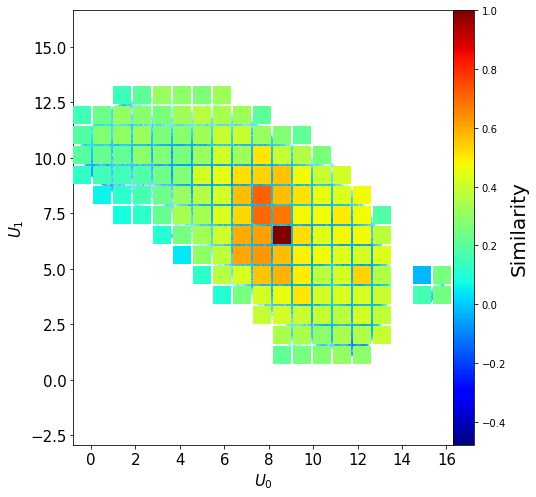

In [36]:
sim_gallery_file = './sim_max_gallery_epoch_20.png'
ax = umap_gallery(valid_tbl, sim_matrix.squeeze(axis=0), sim_gallery_file)

----------------

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [6]:
num_samples = llc_curl_reduced_latents.shape[0]
print(num_samples)

635295


In [7]:
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

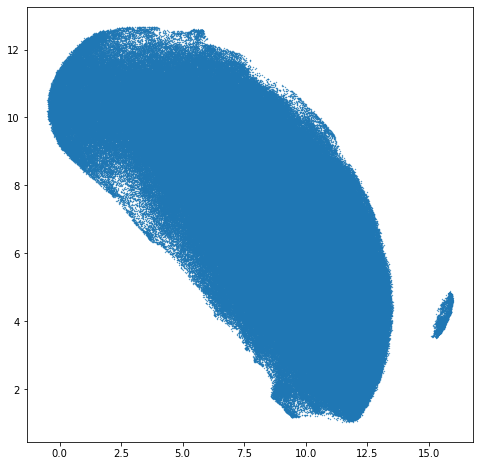

In [8]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)

In [9]:
llc_modis_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/experiments/datasets/llc_kin_dataset/"
llc_modis_curl_file = os.path.join(llc_modis_curl_path, os.listdir(llc_modis_curl_path)[1])

In [ ]:
with h5py.File(llc_modis_curl_file, 'r') as f:
    llc_modis_curl = f['valid'][:]

In [10]:
nbrs = NearestNeighbors(n_neighbors=1024, algorithm='ball_tree').fit(llc_curl_reduced_latents)
distances, indices = nbrs.kneighbors(llc_curl_reduced_latents)

In [96]:
llc_curl_nearest_indices_path = os.path.join(llc_curl_path, 'llc_curl_near_indices.h5')

In [98]:
with h5py.File(llc_curl_nearest_indices_path, 'w') as f:
    f.create_dataset('indices', data=indices)

In [14]:
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)

In [15]:
indice_sets = indices[indice_sampled]
dist_sets = distances[indice_sampled]

In [16]:
indice_sets.shape

(5, 1024)

In [17]:
reduced_latents_subset = []
for i in range(2):
    reduced_latents_subset.append(llc_curl_reduced_latents[indice_sets[i]])

In [18]:
reduced_latents_subset = np.concatenate(reduced_latents_subset, axis=0)

In [19]:
num_samples = llc_curl_reduced_latents.shape[0]
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

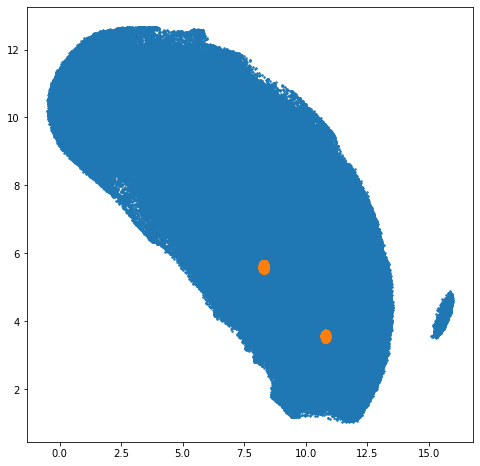

In [21]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size)

In [22]:
indices_combined = [indices[indice_sampled[0]], indices[indice_sampled[1]]]

In [23]:
indices_combined = np.concatenate(indices_combined, axis=0)

In [33]:
latents_subset = llc_curl_latents[indices_combined]

In [34]:
sim_matrix = cosine_similarity(latents_subset)

In [35]:
sim_vector = np.mean(sim_matrix, axis=1)

In [36]:
sim_exp_vector = np.exp(sim_vector)

<AxesSubplot:ylabel='Count'>

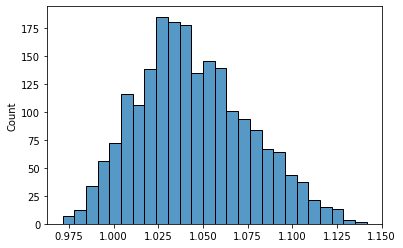

In [37]:
sns.histplot(sim_exp_vector)

<AxesSubplot:ylabel='Count'>

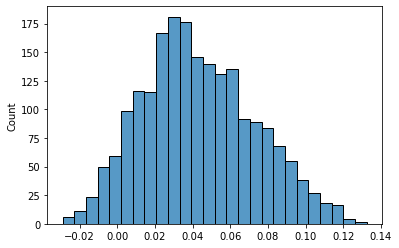

In [38]:
sns.histplot(sim_vector)

<AxesSubplot:ylabel='Count'>

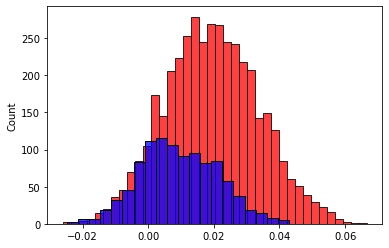

In [64]:
sns.histplot(sim_vector[1024:], color='red')
sns.histplot(sim_vector[:1024], color='blue')

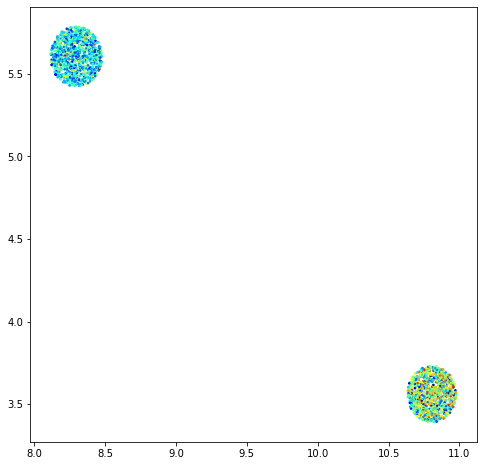

In [45]:
plt.figure(figsize=(width//dpi, height//dpi))
#plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size,
            c=sim_exp_vector, cmap='jet')

In [65]:
reduced_latents_subset = []
for i in range(5):
    reduced_latents_subset.append(llc_curl_reduced_latents[indice_sets[i]])

In [66]:
reduced_latents_subset = np.concatenate(reduced_latents_subset, axis=0)

In [61]:
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

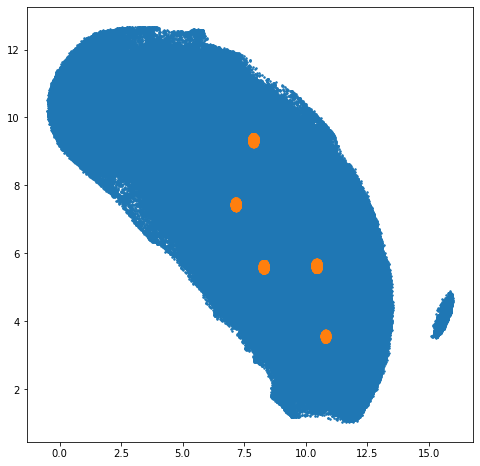

In [48]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size)

In [67]:
indices_combined = [indices[indice_sampled[i]] for i in range(5)]
indices_combined = np.concatenate(indices_combined, axis=0)

In [68]:
latents_subset = llc_curl_latents[indices_combined]

In [69]:
sim_matrix = cosine_similarity(latents_subset)

In [70]:
sim_vector = np.mean(sim_matrix, axis=1)

In [71]:
sim_exp_vector = np.exp(sim_vector)

<AxesSubplot:ylabel='Count'>

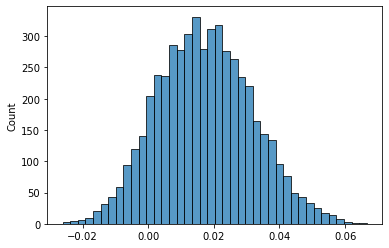

In [72]:
sns.histplot(sim_vector)

<AxesSubplot:ylabel='Count'>

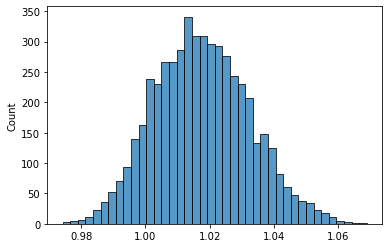

In [73]:
sns.histplot(sim_exp_vector)

<AxesSubplot:ylabel='Count'>

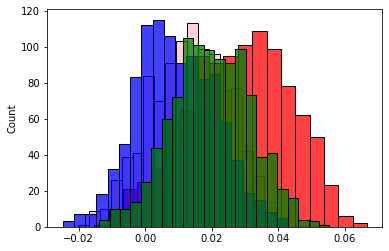

In [81]:
sns.histplot(sim_vector[1024*3: 1024*4], color='pink')
sns.histplot(sim_vector[1024: 2048], color='red')
sns.histplot(sim_vector[: 1024], color='blue')
sns.histplot(sim_vector[1024*3: 1024:4], color='cyan')
sns.histplot(sim_vector[2048: 1024*3], color='green')

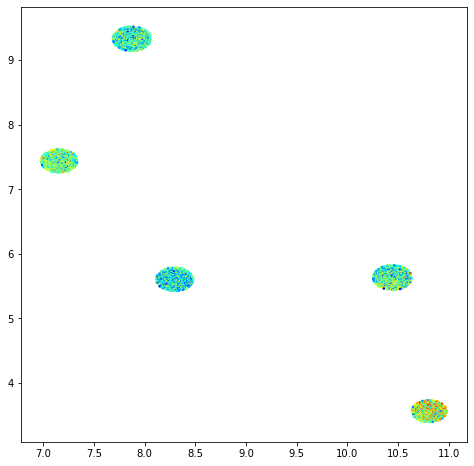

In [56]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size,
            c=sim_exp_vector, cmap='jet')

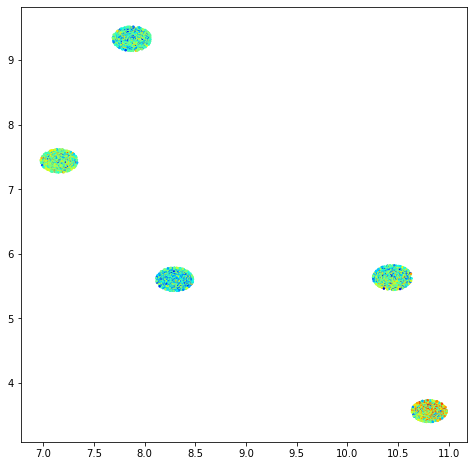

In [57]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size,
            c=sim_vector, cmap='jet')